In [26]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_addon_cutting import cut_gates, generate_cutting_experiments, reconstruct_expectation_values
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer.primitives import EstimatorV2
import numpy as np

# Mapping the circuit

circuit = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit.assign_parameters([0.4]*len(circuit.parameters), inplace=True)

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

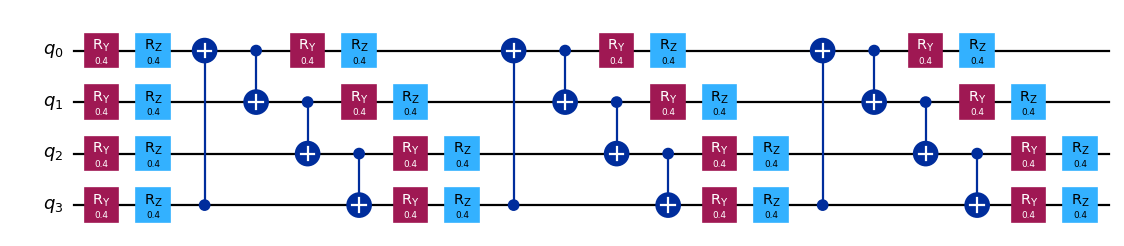

In [27]:
circuit.draw('mpl', scale=0.8)

In [11]:
# Optimize 
backend = FakeManilaV2()

# Transpilation 
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend, initial_layout=[0,1,2,3])
transpiled_qc = pass_manager.run(circuit)
print(f"Transpiled circuit depth: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}")

# Find the indices of the distant gates 
cut_indices = [i for i, instruction in enumerate(circuit.data)
              if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0,3}]

# Decompose distant CNOTs into TwoQubitQPDGate instances 
qpd_circuit, bases = cut_gates(circuit, cut_indices)

Transpiled circuit depth: 30


/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_24945/4040433750.py:7: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  print(f"Transpiled circuit depth: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}")


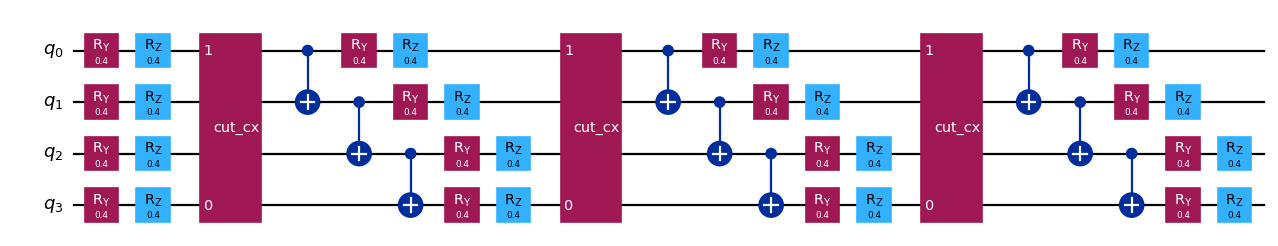

In [12]:
qpd_circuit.draw('mpl', scale=0.8)

In [17]:
# Generating subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf)

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


In [18]:
# Transpile the decomposed circuit 
transpiled_qpd_circuit = pass_manager.run(subexperiments[100])

print(f"Original circuit depth after transpilation: {transpiled_qc.depth(lambda x: len(x[1]) >=2)}")
print(f"QPD subexperiment depth after transpilation: {transpiled_qpd_circuit.depth(lambda x: len(x[1]) >= 2)}")

Original circuit depth after transpilation: 30
QPD subexperiment depth after transpilation: 7


/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_24945/234062355.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  print(f"Original circuit depth after transpilation: {transpiled_qc.depth(lambda x: len(x[1]) >=2)}")
/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_24945/234062355.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  print(f"QPD subexperiment depth after transpilation: {transpiled_qpd_circuit.depth(lambda x: len(x[1]) >= 2)}")


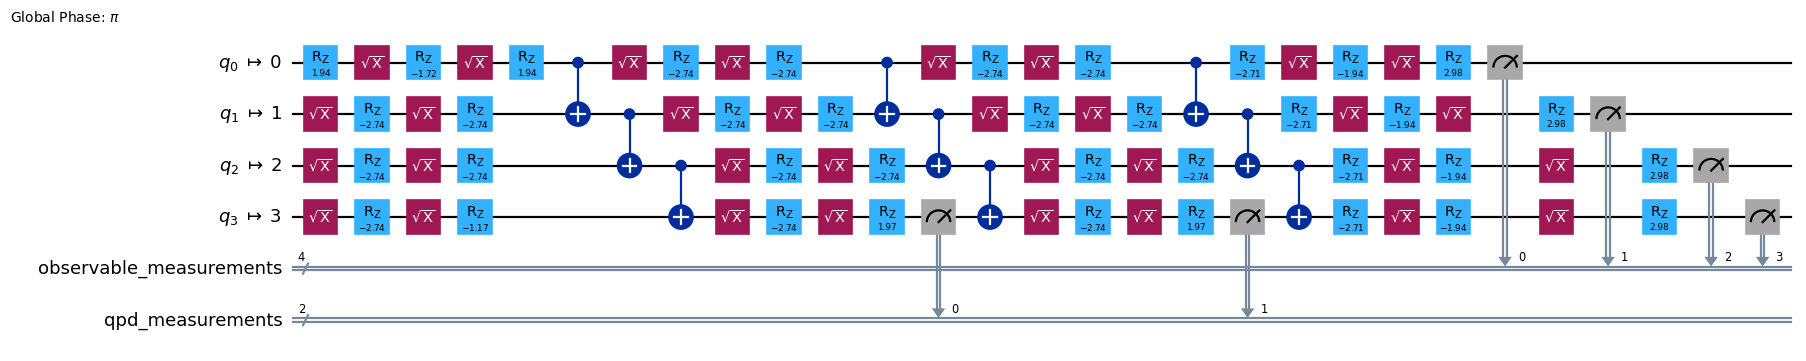

In [19]:
transpiled_qpd_circuit.draw('mpl', scale=0.8, idle_wires=False, fold=-1)

In [20]:
# Transpiling the experiment to the backend's ISA
isa_subexperiments = pass_manager.run(subexperiments)

In [21]:
# Setting up a local simulator in place of Qiskit Primitives
sampler = SamplerV2(backend)
job = sampler.run(isa_subexperiments)

# Results 
results = job.result()

In [28]:

# Post-processing 

reconstructed_expval_terms = reconstruct_expectation_values(results, coefficients, observable.paulis,)
# Reconstruct final expectation values 
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

estimator = EstimatorV2()
exact_expval = estimator.run([(circuit, observable)]).result()[0].data.evs

print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}")

Reconstructed expectation value: 0.49023437
Exact expectation value: 0.50497603
Error in estimation: -0.01474166
Relative error in estimation: -0.02919279
